# Import libraries

In [54]:
from helpers import SEABORN_COLORS, create_plot
import os
import sys
import time
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, regularizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import csv
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PathS

In [55]:
PATH_data = f"/mnt/d/UKB_toydata/"
PATH_GENO = f"{PATH_data}genotype"
PATH_usefull = f"{PATH_data}usefull_values_2"
PATH_PHENO = f"{PATH_data}phenotype"

In [56]:
disease = 'bc'
path = f"{PATH_usefull}/no_corr/{disease}"
sumstat = pd.read_pickle(f"{path}/sumstat.pkl")
pheno = pd.read_pickle(f"{path}/pheno_PRS.pkl")

In [57]:
nr_significant_snps = 300
SNPS = sumstat.sort_values(by=['-logp'])[['snp','#CHROM']].tail(nr_significant_snps)
SNPS = SNPS.sort_values(by=['#CHROM'])
grouped = SNPS.groupby('#CHROM')

# Iterate over groups and create DataFrames
dataframes = {}
for name, group in grouped:
    dataframes[name] = group.copy()

name_file = "total_pop"
# Access each created DataFrame using the unique value as the key
genos_dfs = []
for chrom, dataframe in dataframes.items():
    print(f"DataFrame for chrom {chrom}:\n{dataframe}\n")
    # Define a function to extract ID from snp
    def extract_id(s):
        return s[:-2]  # Remove the last two characters

    # Apply the function to create the 'ID' column
    dataframe['ID'] = dataframe['snp'].apply(extract_id)
    snp_ids_to_keep = " ,".join(list(dataframe['ID']))
    path_total_pop = PATH_GENO + f"/02_per_chrom/total_pop_chr_{chrom}"
    os.system(f"plink2 --bfile {path_total_pop} --snps {snp_ids_to_keep} --recode A --out ./temp2")
    genos = pd.read_csv('./temp2.raw', sep="\t")
    genos = genos.fillna(0)
    to_drop = ['IID','PAT','MAT','SEX', 'PHENOTYPE']
    genos = genos.drop(to_drop, axis=1).astype(int) # encode it as (-1, 0, 1)
    genos_dfs.append(genos)
merged_df = genos_dfs[0]
for df in genos_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='FID')
merged_df

DataFrame for chrom 21:
                     snp #CHROM
7481   21:22313265:C_T_C     21
11139  21:23975186:A_C_A     21
8576   21:33651490:A_G_A     21
2253   21:36191365:A_G_G     21
11029  21:36080290:C_T_C     21
...                  ...    ...
8805   21:35979307:C_T_C     21
2681   21:33583062:C_G_G     21
12688  21:16263419:C_G_C     21
10395  21:36064321:C_T_T     21
1387   21:35554684:A_G_G     21

[109 rows x 2 columns]

PLINK v2.00a5LM 64-bit Intel (21 Jun 2023)     www.cog-genomics.org/plink/2.0/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ./temp2.log.
Options in effect:
  --bfile /mnt/d/UKB_toydata/genotype/02_per_chrom/total_pop_chr_21
  --export A
  --out ./temp2
  --snps 21:22313265:C_T ,21:23975186:A_C ,21:33651490:A_G ,21:36191365:A_G ,21:36080290:C_T ,21:47800628:A_G ,21:30986448:C_T ,21:45365248:C_G ,21:16353531:C_T ,21:36074558:A_C ,21:16288177:G_T ,21:34263801:A_G ,21:43865313:C_T ,21:35826877:C_T ,21:29362621:C_T ,21:36

--export A pass 1/1: loading... 239writing... 101011111212131314141515161617171818192020212122222323242425252626272728282929303031313232333334343535363637373838394040414142424343444445454646474748484949505051515252535354545555565657575858596060616162626363646465656666676768686969707071%71%72%72%73%73%74%74%75%75%76%76%77%77%78%78%79%80%80%81%81%82%82%83%83%84%84%85%85%86%86%87%87%88%88%89%89%90%90%91%91%92%92%93%93%94%94%95%95%96%96%97%97%98%98%99% done.
--export A: ./temp2.raw written.
End time: Tue Sep 19 08:55:35 2023


,FID,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1000052,1,2,2,2,2,2,2,2,2,...,2,0,1,1,1,1,1,2,2,0
1,1000133,2,2,2,1,1,1,1,1,1,...,2,0,0,0,1,1,2,2,2,2
2,1000368,2,2,2,2,2,2,1,1,1,...,2,2,1,1,1,1,2,1,1,1
3,1000473,2,2,1,1,1,1,1,1,1,...,2,1,0,0,2,2,1,2,2,2
4,1000508,2,2,2,2,2,2,2,2,2,...,1,0,2,2,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69450,6026229,0,0,1,0,0,0,0,0,0,...,2,0,2,2,2,2,1,1,1,2
69451,6026253,2,2,2,0,0,0,0,0,0,...,2,2,2,2,2,2,1,2,2,1
69452,6026311,2,2,2,0,0,0,0,2,2,...,2,2,2,2,1,1,1,0,0,1
69453,6026378,2,2,2,0,0,0,0,0,1,...,2,1,2,2,1,1,0,2,2,1


In [58]:
geno = pd.merge(pheno[['FID','phenotype','PRS']], merged_df, on='FID')
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
0,1000133,1,-195.823928,2,2,2,1,1,1,1,...,2,0,0,0,1,1,2,2,2,2
1,1000368,1,264.081506,2,2,2,2,2,2,1,...,2,2,1,1,1,1,2,1,1,1
2,1000566,1,285.314179,2,2,2,1,1,1,2,...,2,1,2,2,2,2,2,2,2,2
3,1000617,1,-10.446365,1,1,2,2,2,2,1,...,1,1,2,2,1,1,1,1,1,1
4,1000655,0,-434.138697,2,2,2,1,1,1,1,...,1,0,2,2,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18450,6025070,1,953.791009,0,2,2,1,1,1,1,...,1,1,1,1,2,2,0,2,2,2
18451,6025369,1,-212.666886,2,2,2,1,1,1,1,...,1,1,2,2,1,1,0,2,2,1
18452,6025436,1,375.888514,2,2,2,1,1,1,1,...,1,2,1,1,1,1,0,2,2,2
18453,6025535,1,29.866073,2,2,1,1,1,1,2,...,1,2,2,2,2,2,2,2,2,2


In [59]:
# Split DataFrame into controls to train the model and cases and controls to calculate PRS
cases_df = geno[geno['phenotype'] == 1]
cases_df = cases_df.sample(frac=1, random_state=42)
train_cases = cases_df.head(len(cases_df)//2)
replicated_cases = cases_df.tail(len(cases_df) - len(cases_df)//2)

controls_df = geno[geno['phenotype'] == 0]
controls_df = controls_df.sample(frac=1, random_state=42)
train_controls = controls_df.head(len(controls_df)//2)
replicated_controls = controls_df.tail(len(controls_df) - len(controls_df)//2)

smallest_size = min(len(train_cases), len(replicated_cases) ,len(train_controls), len(replicated_controls))

train_cases = train_cases.head(smallest_size)
replicated_cases = replicated_cases.head(smallest_size)
train_controls = train_controls.head(smallest_size)
replicated_controls = replicated_controls.head(smallest_size)

In [60]:
train_cases

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
2330,1639532,1,-76.657170,2,2,2,0,0,0,0,...,2,0,2,2,0,0,1,2,2,2
2050,1569113,1,211.408840,2,2,2,0,0,0,0,...,1,2,1,1,1,1,2,1,1,2
18436,6021484,1,143.950755,2,2,2,1,1,1,1,...,2,1,2,2,1,1,1,2,2,2
1805,1505477,1,-212.706129,1,1,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,2
16994,5635446,1,-211.342136,1,1,2,2,2,2,2,...,1,2,1,1,0,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11851,4262562,1,813.300224,2,2,2,0,0,0,0,...,1,0,1,1,1,1,1,2,2,2
8374,3293793,1,733.147892,1,1,2,0,0,0,0,...,0,1,2,2,2,2,1,2,2,0
5415,2473522,1,182.432651,2,2,2,1,1,1,2,...,2,2,1,1,2,2,2,1,1,1
14727,5016905,1,590.350506,2,2,2,2,2,2,2,...,2,1,2,2,1,1,2,0,0,2


In [61]:
train_controls

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
2397,1654317,0,-932.026041,2,2,2,1,1,1,1,...,2,1,1,1,0,0,1,2,2,1
2114,1585417,0,-485.629184,2,2,2,0,0,0,0,...,1,1,1,1,2,2,0,1,1,1
18433,6020676,0,-124.109258,2,2,2,1,1,1,1,...,2,0,2,2,2,2,0,2,2,2
1825,1510558,0,-673.673848,2,2,2,1,1,1,1,...,0,1,1,1,2,2,1,2,2,1
16979,5632637,0,-497.336991,1,1,1,1,1,1,1,...,1,2,1,1,1,1,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11886,4269378,0,-315.418448,2,2,1,1,1,1,0,...,2,2,2,2,0,0,1,1,1,1
8271,3261831,0,-325.464633,2,2,2,1,1,1,1,...,0,1,2,2,0,0,1,2,2,1
5323,2446444,0,-339.877061,2,2,1,1,1,1,1,...,2,1,1,1,1,1,0,2,2,2
14773,5027337,0,-689.406952,2,2,1,2,2,2,2,...,2,1,1,1,1,0,0,1,1,1


In [62]:
geno = pd.concat([train_cases,train_controls], axis = 0)

In [63]:
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
2330,1639532,1,-76.657170,2,2,2,0,0,0,0,...,2,0,2,2,0,0,1,2,2,2
2050,1569113,1,211.408840,2,2,2,0,0,0,0,...,1,2,1,1,1,1,2,1,1,2
18436,6021484,1,143.950755,2,2,2,1,1,1,1,...,2,1,2,2,1,1,1,2,2,2
1805,1505477,1,-212.706129,1,1,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,2
16994,5635446,1,-211.342136,1,1,2,2,2,2,2,...,1,2,1,1,0,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11886,4269378,0,-315.418448,2,2,1,1,1,1,0,...,2,2,2,2,0,0,1,1,1,1
8271,3261831,0,-325.464633,2,2,2,1,1,1,1,...,0,1,2,2,0,0,1,2,2,1
5323,2446444,0,-339.877061,2,2,1,1,1,1,1,...,2,1,1,1,1,1,0,2,2,2
14773,5027337,0,-689.406952,2,2,1,2,2,2,2,...,2,1,1,1,1,0,0,1,1,1


In [64]:
to_drop = ['FID','phenotype','PRS']
geno_input = geno.drop(to_drop, axis=1).astype(int) -1
pheno_input = geno[['phenotype']]

# Create model

In [65]:
input_shape_geno = geno_input.shape
input_layer_geno = Input(shape=input_shape_geno[1:], name='input_geno')

input_shape_pheno = pheno_input.shape
input_layer_pheno = Input(shape=input_shape_pheno[1:], name='input_pheno')

bottle = 2
size_layer_1 = int(round(input_shape_geno[1] + bottle)/2)

# Define your regularization strength (lambda)
l2_lambda = 0.001  # Adjust this value as needed

# Create layers

# Create layers
encoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="encoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

encoder_init_2 = layers.Dense(bottle, 
                       activation="linear", 
                       name="encoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="decoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_2 = layers.Dense(input_shape_geno[1], 
                       activation="linear", 
                       name="decoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))



encoder_concat_1 = layers.Dense(size_layer_1, 
                       activation="elu", 
                       name="encoder_concat_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

encoder_concat_2 = layers.Dense(input_shape_pheno[1], 
                       activation="sigmoid", 
                       name="encoder_concat_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_concat_1 = layers.Dense(size_layer_1, 
                       activation="linear", 
                       name="decoder_concat_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_concat_2 = layers.Dense(input_shape_geno[1] + bottle, 
                       activation="linear", 
                       name="decoder_concat_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

In [66]:
bottle_neck = encoder_init_2(encoder_init_1(input_layer_geno))

In [67]:
concatenated_bottle = tf.concat([bottle_neck, input_layer_pheno], axis=1)
concatenated_inputs = tf.concat([bottle_neck, input_layer_geno], axis=1)

In [68]:
shape_zeros = concatenated_inputs.shape
dec_init_1 = decoder_init_1(concatenated_bottle)
X2 = decoder_init_2(dec_init_1)
y = encoder_concat_2(encoder_concat_1(concatenated_inputs))
conc_X2 = decoder_concat_2(decoder_concat_1(y))
squared_difference = tf.square(conc_X2 - concatenated_inputs)
model = Model(inputs = [input_layer_geno, input_layer_pheno], outputs = [X2, y, squared_difference], name = "fishy")

In [69]:
model.summary()

Model: "fishy"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_geno (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 encoder_init_1 (Dense)         (None, 151)          45451       ['input_geno[0][0]']             
                                                                                                  
 encoder_init_2 (Dense)         (None, 2)            304         ['encoder_init_1[0][0]']         
                                                                                                  
 tf.concat_3 (TFOpLambda)       (None, 302)          0           ['encoder_init_2[0][0]',         
                                                                  'input_geno[0][0]']         

In [70]:
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
2330,1639532,1,-76.657170,2,2,2,0,0,0,0,...,2,0,2,2,0,0,1,2,2,2
2050,1569113,1,211.408840,2,2,2,0,0,0,0,...,1,2,1,1,1,1,2,1,1,2
18436,6021484,1,143.950755,2,2,2,1,1,1,1,...,2,1,2,2,1,1,1,2,2,2
1805,1505477,1,-212.706129,1,1,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,2
16994,5635446,1,-211.342136,1,1,2,2,2,2,2,...,1,2,1,1,0,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11886,4269378,0,-315.418448,2,2,1,1,1,1,0,...,2,2,2,2,0,0,1,1,1,1
8271,3261831,0,-325.464633,2,2,2,1,1,1,1,...,0,1,2,2,0,0,1,2,2,1
5323,2446444,0,-339.877061,2,2,1,1,1,1,1,...,2,1,1,1,1,1,0,2,2,2
14773,5027337,0,-689.406952,2,2,1,2,2,2,2,...,2,1,1,1,1,0,0,1,1,1


In [71]:
genos = geno.sample(frac=1)
pheno = genos[['phenotype']].astype(int)
genos = genos.drop(to_drop, axis=1)
len_test = round(genos.shape[0]/10)*3
len_train = genos.shape[0] - len_test
X_train = genos.head(len_train) - 1
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = genos.tail(len_test) - 1
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

shape_train = (len_train,squared_difference.shape[1])
shape_test = (len_test,squared_difference.shape[1])

In [72]:
pheno_tensor_train  = tf.convert_to_tensor(pheno.head(len_train))
pheno_tensor_test = tf.convert_to_tensor(pheno.tail(len_test))

In [73]:
pheno_tensor_train

<tf.Tensor: shape=(6457, 1), dtype=int64, numpy=
array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])>

In [74]:
epoch = 200
optimizer='Adam'
loss = 'mse'
zero_tensor_train = tf.zeros(shape_train, dtype=tf.float32)
zero_tensor_test = tf.zeros(shape_test, dtype=tf.float32)
model.compile(optimizer,  loss=['mse', 'binary_crossentropy', 'mse'], metrics = ["mse"])

In [75]:
history = model.fit([X_train,pheno_tensor_train],
            [X_train, pheno_tensor_train, zero_tensor_train],
            validation_data=([X_test, pheno_tensor_test], 
                             [X_test, pheno_tensor_test, zero_tensor_test]),
            epochs = epoch,
            verbose = 1)

Epoch 1/200
202/202 [==============================] - 3s 7ms/step - loss: 1.9410 - decoder_init_2_loss: 0.3595 - encoder_concat_2_loss: 0.7370 - tf.math.square_1_loss: 0.3219 - decoder_init_2_mse: 0.3595 - encoder_concat_2_mse: 0.2681 - tf.math.square_1_mse: 0.3219 - val_loss: 1.6297 - val_decoder_init_2_loss: 0.3070 - val_encoder_concat_2_loss: 0.7008 - val_tf.math.square_1_loss: 0.2854 - val_decoder_init_2_mse: 0.3070 - val_encoder_concat_2_mse: 0.2531 - val_tf.math.square_1_mse: 0.2854
Epoch 2/200
202/202 [==============================] - 1s 6ms/step - loss: 1.5485 - decoder_init_2_loss: 0.3020 - encoder_concat_2_loss: 0.6904 - tf.math.square_1_loss: 0.2835 - decoder_init_2_mse: 0.3020 - encoder_concat_2_mse: 0.2480 - tf.math.square_1_mse: 0.2835 - val_loss: 1.5139 - val_decoder_init_2_loss: 0.3021 - val_encoder_concat_2_loss: 0.7035 - val_tf.math.square_1_loss: 0.2835 - val_decoder_init_2_mse: 0.3021 - val_encoder_concat_2_mse: 0.2545 - val_tf.math.square_1_mse: 0.2835
Epoch 3/20

Epoch 18/200
202/202 [==============================] - 1s 7ms/step - loss: 1.2545 - decoder_init_2_loss: 0.2863 - encoder_concat_2_loss: 0.6388 - tf.math.square_1_loss: 0.2794 - decoder_init_2_mse: 0.2863 - encoder_concat_2_mse: 0.2241 - tf.math.square_1_mse: 0.2794 - val_loss: 1.3145 - val_decoder_init_2_loss: 0.2891 - val_encoder_concat_2_loss: 0.6935 - val_tf.math.square_1_loss: 0.2822 - val_decoder_init_2_mse: 0.2891 - val_encoder_concat_2_mse: 0.2495 - val_tf.math.square_1_mse: 0.2822
Epoch 19/200
202/202 [==============================] - 1s 6ms/step - loss: 1.2550 - decoder_init_2_loss: 0.2864 - encoder_concat_2_loss: 0.6394 - tf.math.square_1_loss: 0.2793 - decoder_init_2_mse: 0.2864 - encoder_concat_2_mse: 0.2245 - tf.math.square_1_mse: 0.2793 - val_loss: 1.3201 - val_decoder_init_2_loss: 0.2886 - val_encoder_concat_2_loss: 0.6999 - val_tf.math.square_1_loss: 0.2818 - val_decoder_init_2_mse: 0.2886 - val_encoder_concat_2_mse: 0.2519 - val_tf.math.square_1_mse: 0.2818
Epoch 20

202/202 [==============================] - 1s 6ms/step - loss: 1.2028 - decoder_init_2_loss: 0.2859 - encoder_concat_2_loss: 0.5756 - tf.math.square_1_loss: 0.2781 - decoder_init_2_mse: 0.2859 - encoder_concat_2_mse: 0.1960 - tf.math.square_1_mse: 0.2781 - val_loss: 1.3639 - val_decoder_init_2_loss: 0.2878 - val_encoder_concat_2_loss: 0.7311 - val_tf.math.square_1_loss: 0.2812 - val_decoder_init_2_mse: 0.2878 - val_encoder_concat_2_mse: 0.2641 - val_tf.math.square_1_mse: 0.2812
Epoch 35/200
202/202 [==============================] - 1s 6ms/step - loss: 1.2013 - decoder_init_2_loss: 0.2859 - encoder_concat_2_loss: 0.5728 - tf.math.square_1_loss: 0.2782 - decoder_init_2_mse: 0.2859 - encoder_concat_2_mse: 0.1948 - tf.math.square_1_mse: 0.2782 - val_loss: 1.3913 - val_decoder_init_2_loss: 0.2879 - val_encoder_concat_2_loss: 0.7572 - val_tf.math.square_1_loss: 0.2811 - val_decoder_init_2_mse: 0.2879 - val_encoder_concat_2_mse: 0.2730 - val_tf.math.square_1_mse: 0.2811
Epoch 36/200
202/202 

Epoch 51/200
202/202 [==============================] - 1s 6ms/step - loss: 1.1436 - decoder_init_2_loss: 0.2858 - encoder_concat_2_loss: 0.4903 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2858 - encoder_concat_2_mse: 0.1605 - tf.math.square_1_mse: 0.2779 - val_loss: 1.4765 - val_decoder_init_2_loss: 0.2880 - val_encoder_concat_2_loss: 0.8173 - val_tf.math.square_1_loss: 0.2809 - val_decoder_init_2_mse: 0.2880 - val_encoder_concat_2_mse: 0.2907 - val_tf.math.square_1_mse: 0.2809
Epoch 52/200
202/202 [==============================] - 1s 6ms/step - loss: 1.1440 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.4891 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.1604 - tf.math.square_1_mse: 0.2779 - val_loss: 1.4563 - val_decoder_init_2_loss: 0.2880 - val_encoder_concat_2_loss: 0.7955 - val_tf.math.square_1_loss: 0.2810 - val_decoder_init_2_mse: 0.2880 - val_encoder_concat_2_mse: 0.2822 - val_tf.math.square_1_mse: 0.2810
Epoch 53

202/202 [==============================] - 1s 6ms/step - loss: 1.0986 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.4193 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.1326 - tf.math.square_1_mse: 0.2778 - val_loss: 1.5674 - val_decoder_init_2_loss: 0.2881 - val_encoder_concat_2_loss: 0.8826 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2881 - val_encoder_concat_2_mse: 0.3031 - val_tf.math.square_1_mse: 0.2807
Epoch 68/200
202/202 [==============================] - 1s 5ms/step - loss: 1.0957 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.4154 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.1312 - tf.math.square_1_mse: 0.2778 - val_loss: 1.5532 - val_decoder_init_2_loss: 0.2878 - val_encoder_concat_2_loss: 0.8673 - val_tf.math.square_1_loss: 0.2806 - val_decoder_init_2_mse: 0.2878 - val_encoder_concat_2_mse: 0.2985 - val_tf.math.square_1_mse: 0.2806
Epoch 69/200
202/202 

Epoch 84/200
202/202 [==============================] - 1s 6ms/step - loss: 1.0588 - decoder_init_2_loss: 0.2856 - encoder_concat_2_loss: 0.3541 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2856 - encoder_concat_2_mse: 0.1080 - tf.math.square_1_mse: 0.2778 - val_loss: 1.6784 - val_decoder_init_2_loss: 0.2877 - val_encoder_concat_2_loss: 0.9683 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2877 - val_encoder_concat_2_mse: 0.3211 - val_tf.math.square_1_mse: 0.2807
Epoch 85/200
202/202 [==============================] - 1s 6ms/step - loss: 1.0632 - decoder_init_2_loss: 0.2856 - encoder_concat_2_loss: 0.3571 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2856 - encoder_concat_2_mse: 0.1094 - tf.math.square_1_mse: 0.2778 - val_loss: 1.6835 - val_decoder_init_2_loss: 0.2878 - val_encoder_concat_2_loss: 0.9714 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2878 - val_encoder_concat_2_mse: 0.3203 - val_tf.math.square_1_mse: 0.2807
Epoch 86

202/202 [==============================] - 1s 6ms/step - loss: 1.0329 - decoder_init_2_loss: 0.2856 - encoder_concat_2_loss: 0.3068 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2856 - encoder_concat_2_mse: 0.0911 - tf.math.square_1_mse: 0.2778 - val_loss: 1.8309 - val_decoder_init_2_loss: 0.2877 - val_encoder_concat_2_loss: 1.0994 - val_tf.math.square_1_loss: 0.2806 - val_decoder_init_2_mse: 0.2877 - val_encoder_concat_2_mse: 0.3410 - val_tf.math.square_1_mse: 0.2806
Epoch 101/200
202/202 [==============================] - 1s 6ms/step - loss: 1.0317 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.3043 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0898 - tf.math.square_1_mse: 0.2779 - val_loss: 1.7636 - val_decoder_init_2_loss: 0.2878 - val_encoder_concat_2_loss: 1.0304 - val_tf.math.square_1_loss: 0.2809 - val_decoder_init_2_mse: 0.2878 - val_encoder_concat_2_mse: 0.3279 - val_tf.math.square_1_mse: 0.2809
Epoch 102/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 1.0123 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.2680 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0768 - tf.math.square_1_mse: 0.2779 - val_loss: 1.8448 - val_decoder_init_2_loss: 0.2876 - val_encoder_concat_2_loss: 1.0954 - val_tf.math.square_1_loss: 0.2808 - val_decoder_init_2_mse: 0.2876 - val_encoder_concat_2_mse: 0.3370 - val_tf.math.square_1_mse: 0.2808
Epoch 117/200
202/202 [==============================] - 1s 6ms/step - loss: 1.0168 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.2718 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0784 - tf.math.square_1_mse: 0.2779 - val_loss: 1.9139 - val_decoder_init_2_loss: 0.2881 - val_encoder_concat_2_loss: 1.1635 - val_tf.math.square_1_loss: 0.2804 - val_decoder_init_2_mse: 0.2881 - val_encoder_concat_2_mse: 0.3498 - val_tf.math.square_1_mse: 0.2804
Epoch 118/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 0.9970 - decoder_init_2_loss: 0.2858 - encoder_concat_2_loss: 0.2387 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2858 - encoder_concat_2_mse: 0.0662 - tf.math.square_1_mse: 0.2779 - val_loss: 1.9780 - val_decoder_init_2_loss: 0.2879 - val_encoder_concat_2_loss: 1.2137 - val_tf.math.square_1_loss: 0.2812 - val_decoder_init_2_mse: 0.2879 - val_encoder_concat_2_mse: 0.3551 - val_tf.math.square_1_mse: 0.2812
Epoch 133/200
202/202 [==============================] - 1s 6ms/step - loss: 0.9970 - decoder_init_2_loss: 0.2856 - encoder_concat_2_loss: 0.2381 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2856 - encoder_concat_2_mse: 0.0664 - tf.math.square_1_mse: 0.2779 - val_loss: 1.9480 - val_decoder_init_2_loss: 0.2879 - val_encoder_concat_2_loss: 1.1839 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2879 - val_encoder_concat_2_mse: 0.3520 - val_tf.math.square_1_mse: 0.2807
Epoch 134/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 0.9901 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.2205 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0604 - tf.math.square_1_mse: 0.2779 - val_loss: 1.9992 - val_decoder_init_2_loss: 0.2876 - val_encoder_concat_2_loss: 1.2240 - val_tf.math.square_1_loss: 0.2810 - val_decoder_init_2_mse: 0.2876 - val_encoder_concat_2_mse: 0.3566 - val_tf.math.square_1_mse: 0.2810
Epoch 149/200
202/202 [==============================] - 1s 6ms/step - loss: 0.9890 - decoder_init_2_loss: 0.2855 - encoder_concat_2_loss: 0.2191 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2855 - encoder_concat_2_mse: 0.0595 - tf.math.square_1_mse: 0.2778 - val_loss: 2.0070 - val_decoder_init_2_loss: 0.2877 - val_encoder_concat_2_loss: 1.2315 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2877 - val_encoder_concat_2_mse: 0.3555 - val_tf.math.square_1_mse: 0.2807
Epoch 150/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 0.9800 - decoder_init_2_loss: 0.2855 - encoder_concat_2_loss: 0.2022 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2855 - encoder_concat_2_mse: 0.0536 - tf.math.square_1_mse: 0.2779 - val_loss: 2.0544 - val_decoder_init_2_loss: 0.2881 - val_encoder_concat_2_loss: 1.2713 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2881 - val_encoder_concat_2_mse: 0.3620 - val_tf.math.square_1_mse: 0.2807
Epoch 165/200
202/202 [==============================] - 1s 6ms/step - loss: 0.9958 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.2168 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0598 - tf.math.square_1_mse: 0.2779 - val_loss: 2.0580 - val_decoder_init_2_loss: 0.2879 - val_encoder_concat_2_loss: 1.2743 - val_tf.math.square_1_loss: 0.2808 - val_decoder_init_2_mse: 0.2879 - val_encoder_concat_2_mse: 0.3643 - val_tf.math.square_1_mse: 0.2808
Epoch 166/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 0.9795 - decoder_init_2_loss: 0.2867 - encoder_concat_2_loss: 0.1934 - tf.math.square_1_loss: 0.2782 - decoder_init_2_mse: 0.2867 - encoder_concat_2_mse: 0.0506 - tf.math.square_1_mse: 0.2782 - val_loss: 2.0788 - val_decoder_init_2_loss: 0.2876 - val_encoder_concat_2_loss: 1.2883 - val_tf.math.square_1_loss: 0.2809 - val_decoder_init_2_mse: 0.2876 - val_encoder_concat_2_mse: 0.3626 - val_tf.math.square_1_mse: 0.2809
Epoch 181/200
202/202 [==============================] - 1s 6ms/step - loss: 1.0042 - decoder_init_2_loss: 0.2857 - encoder_concat_2_loss: 0.2185 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2857 - encoder_concat_2_mse: 0.0613 - tf.math.square_1_mse: 0.2779 - val_loss: 2.0881 - val_decoder_init_2_loss: 0.2879 - val_encoder_concat_2_loss: 1.2973 - val_tf.math.square_1_loss: 0.2807 - val_decoder_init_2_mse: 0.2879 - val_encoder_concat_2_mse: 0.3654 - val_tf.math.square_1_mse: 0.2807
Epoch 182/200
202/20

202/202 [==============================] - 1s 6ms/step - loss: 0.9714 - decoder_init_2_loss: 0.2855 - encoder_concat_2_loss: 0.1827 - tf.math.square_1_loss: 0.2779 - decoder_init_2_mse: 0.2855 - encoder_concat_2_mse: 0.0474 - tf.math.square_1_mse: 0.2779 - val_loss: 2.1007 - val_decoder_init_2_loss: 0.2887 - val_encoder_concat_2_loss: 1.3058 - val_tf.math.square_1_loss: 0.2806 - val_decoder_init_2_mse: 0.2887 - val_encoder_concat_2_mse: 0.3642 - val_tf.math.square_1_mse: 0.2806
Epoch 197/200
202/202 [==============================] - 1s 6ms/step - loss: 0.9663 - decoder_init_2_loss: 0.2856 - encoder_concat_2_loss: 0.1772 - tf.math.square_1_loss: 0.2778 - decoder_init_2_mse: 0.2856 - encoder_concat_2_mse: 0.0445 - tf.math.square_1_mse: 0.2778 - val_loss: 2.1328 - val_decoder_init_2_loss: 0.2878 - val_encoder_concat_2_loss: 1.3382 - val_tf.math.square_1_loss: 0.2805 - val_decoder_init_2_mse: 0.2878 - val_encoder_concat_2_mse: 0.3707 - val_tf.math.square_1_mse: 0.2805
Epoch 198/200
202/20

In [76]:
vals = model.history.history
vali = list(vals.keys())
loss = vals[vali[0]]
decoder_loss = vals[vali[1]]
encoder_loss = vals[vali[2]]
decoder_accuracy = vals[vali[3]]
decoder_mse = vals[vali[4]]
encoder_accuracy = vals[vali[5]]
encoder_mse = vals[vali[6]]

val_loss = vals[vali[7]]
val_decoder_loss = vals[vali[8]]
val_encoder_loss = vals[vali[9]]
val_decoder_accuracy = vals[vali[10]]
val_decoder_mse = vals[vali[11]]
val_encoder_accuracy = vals[vali[12]]
val_encoder_mse = vals[vali[13]]

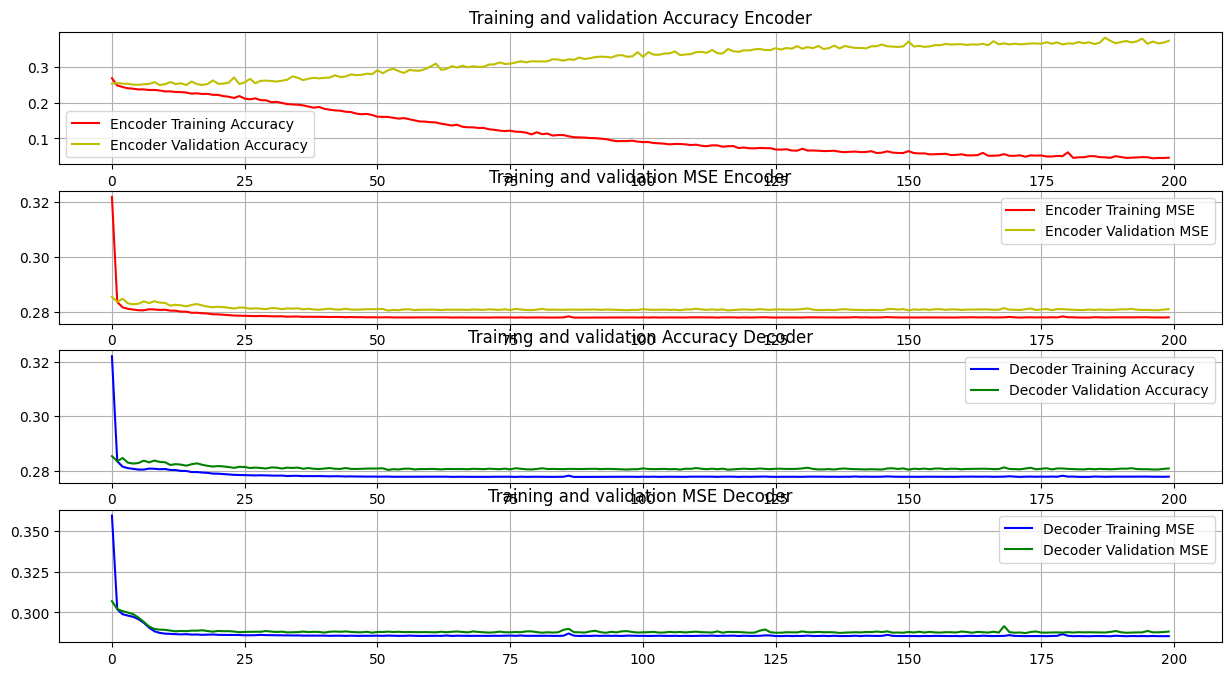

In [77]:
epochsticks = range(len(val_loss))
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(511)
ax1.plot(epochsticks, encoder_accuracy, 'r', label = 'Encoder Training Accuracy')
ax1.plot(epochsticks, val_encoder_accuracy, 'y', label = 'Encoder Validation Accuracy')
ax1.set_title('Training and validation Accuracy Encoder')
ax1.grid()
ax1.legend()

ax2 = plt.subplot(512, sharex = ax1)
ax2.plot(epochsticks, encoder_mse, 'r', label = 'Encoder Training MSE')
ax2.plot(epochsticks, val_encoder_mse, 'y', label = 'Encoder Validation MSE')
ax2.set_title('Training and validation MSE Encoder')
ax2.grid()
ax2.legend()

ax3 = plt.subplot(513, sharex = ax1)
ax3.plot(epochsticks, decoder_accuracy, 'b', label = 'Decoder Training Accuracy')
ax3.plot(epochsticks, val_decoder_accuracy, 'g', label = 'Decoder Validation Accuracy')
ax3.set_title('Training and validation Accuracy Decoder')
ax3.grid()
ax3.legend()

ax4 = plt.subplot(514, sharex = ax1)

ax4.plot(epochsticks, decoder_mse, 'b', label = 'Decoder Training MSE')
ax4.plot(epochsticks, val_decoder_mse, 'g', label = 'Decoder Validation MSE')
ax4.set_title('Training and validation MSE Decoder')
ax4.grid()
ax4.legend()

In [78]:
geno

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
2330,1639532,1,-76.657170,2,2,2,0,0,0,0,...,2,0,2,2,0,0,1,2,2,2
2050,1569113,1,211.408840,2,2,2,0,0,0,0,...,1,2,1,1,1,1,2,1,1,2
18436,6021484,1,143.950755,2,2,2,1,1,1,1,...,2,1,2,2,1,1,1,2,2,2
1805,1505477,1,-212.706129,1,1,2,2,2,2,2,...,2,2,2,2,2,2,1,2,2,2
16994,5635446,1,-211.342136,1,1,2,2,2,2,2,...,1,2,1,1,0,0,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11886,4269378,0,-315.418448,2,2,1,1,1,1,0,...,2,2,2,2,0,0,1,1,1,1
8271,3261831,0,-325.464633,2,2,2,1,1,1,1,...,0,1,2,2,0,0,1,2,2,1
5323,2446444,0,-339.877061,2,2,1,1,1,1,1,...,2,1,1,1,1,1,0,2,2,2
14773,5027337,0,-689.406952,2,2,1,2,2,2,2,...,2,1,1,1,1,0,0,1,1,1


In [79]:
genos = geno.sample(frac=1)
pheno = genos[['phenotype']].astype(int)
genos = genos.drop(to_drop, axis=1)

In [80]:
genos = genos - 1
genos

,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,21:16353531:C_T_T,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
11018,0,0,1,0,0,1,-1,0,0,1,...,0,0,0,0,0,0,0,1,1,1
11260,1,1,0,-1,-1,-1,-1,-1,-1,1,...,0,1,1,1,1,1,1,1,1,1
3485,1,1,1,0,0,0,0,0,0,1,...,0,1,1,1,0,0,0,1,1,1
17168,1,1,1,1,1,1,-1,-1,-1,1,...,1,-1,0,0,0,0,1,0,0,1
15943,0,0,1,0,0,0,0,0,0,0,...,1,-1,-1,-1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,1,1,1,-1,-1,-1,0,0,0,1,...,0,0,1,1,1,1,0,0,0,1
1106,0,0,0,0,0,0,0,0,0,1,...,1,0,1,1,1,1,0,1,1,1
3646,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,0,1,1,1
14860,1,1,1,0,0,0,0,0,0,1,...,1,0,1,1,1,1,0,1,1,0


In [81]:
pheno

,phenotype
11018,1
11260,1
3485,1
17168,0
15943,1
...,...
1023,1
1106,1
3646,1
14860,0


In [82]:
X1 = tf.convert_to_tensor(genos, dtype=tf.float32)
X2 = tf.convert_to_tensor(pheno, dtype=tf.float32)
output_model = model([X1,X2])
submodel_layers1 = model.layers[:3]
submodel1 = Model(inputs=[model.input[0]], outputs=submodel_layers1[-1].output)
submodel1(X1)

<tf.Tensor: shape=(9226, 2), dtype=float32, numpy=
array([[ 0.77613497,  0.45636988],
       [ 1.3080835 ,  1.0534981 ],
       [-0.24534535,  0.40934855],
       ...,
       [ 0.02842975,  0.68472993],
       [-0.78576124, -0.65740275],
       [-0.12510657, -0.7886652 ]], dtype=float32)>

In [83]:
submodel_layers2 = model.layers[:6]
submodel2 = Model(inputs=[model.input[0]], outputs=submodel_layers2[-1].output)
submodel2(X1)

<tf.Tensor: shape=(9226, 1), dtype=float32, numpy=
array([[0.56647843],
       [0.7577964 ],
       [0.9562826 ],
       ...,
       [0.7302339 ],
       [0.12642735],
       [0.9951561 ]], dtype=float32)>

In [84]:
submodel_layers3 = model.layers[:16]
submodel3 = Model(inputs=[model.input[0]], outputs=submodel_layers3[-1].output)
submodel3(X1)

<tf.Tensor: shape=(9226, 302), dtype=float32, numpy=
array([[0.44230914, 0.15763675, 0.21403804, ..., 0.46035925, 0.49901348,
        0.40592122],
       [1.4325762 , 0.98840374, 0.28869408, ..., 0.4604369 , 0.49917972,
        0.40596354],
       [0.12719159, 0.12254058, 0.28863287, ..., 0.46051747, 0.49935222,
        0.40600735],
       ...,
       [0.00684513, 0.39114216, 0.28870255, ..., 0.46042573, 0.4991558 ,
        0.40595746],
       [0.8038594 , 0.5137847 , 0.28888884, ..., 0.46018076, 0.4986314 ,
        0.13173768],
       [0.05589569, 0.7190215 , 0.21415195, ..., 0.46053326, 0.49938592,
        0.40601593]], dtype=float32)>

In [85]:
cols = []
for i2 in range(np.shape(submodel1(X1))[1]):
    cols.append(f'dim{i2+1}')
bottleneck_1 = pd.DataFrame(submodel1(X1), columns = cols)
cols = []
for i2 in range(np.shape(submodel2(X1))[1]):
    cols.append(f'pheno{i2+1}')
predicted_pheno = pd.DataFrame(submodel2(X1), columns = cols)

In [86]:
predicted_pheno

,pheno1
0,0.566478
1,0.757796
2,0.956283
3,0.178289
4,0.896805
...,...
9221,0.947334
9222,0.089585
9223,0.730234
9224,0.126427


In [87]:
bottleneck_1

,dim1,dim2
0,0.776135,0.456370
1,1.308084,1.053498
2,-0.245345,0.409349
3,-0.316710,-0.745426
4,-0.698589,0.131350
...,...,...
9221,-0.258095,1.223190
9222,0.750072,1.221986
9223,0.028430,0.684730
9224,-0.785761,-0.657403


In [88]:
bottleneck_1['phenotype'] = list(pheno['phenotype'])
bottleneck_1['predicted phenotype'] = list(predicted_pheno['pheno1'])

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

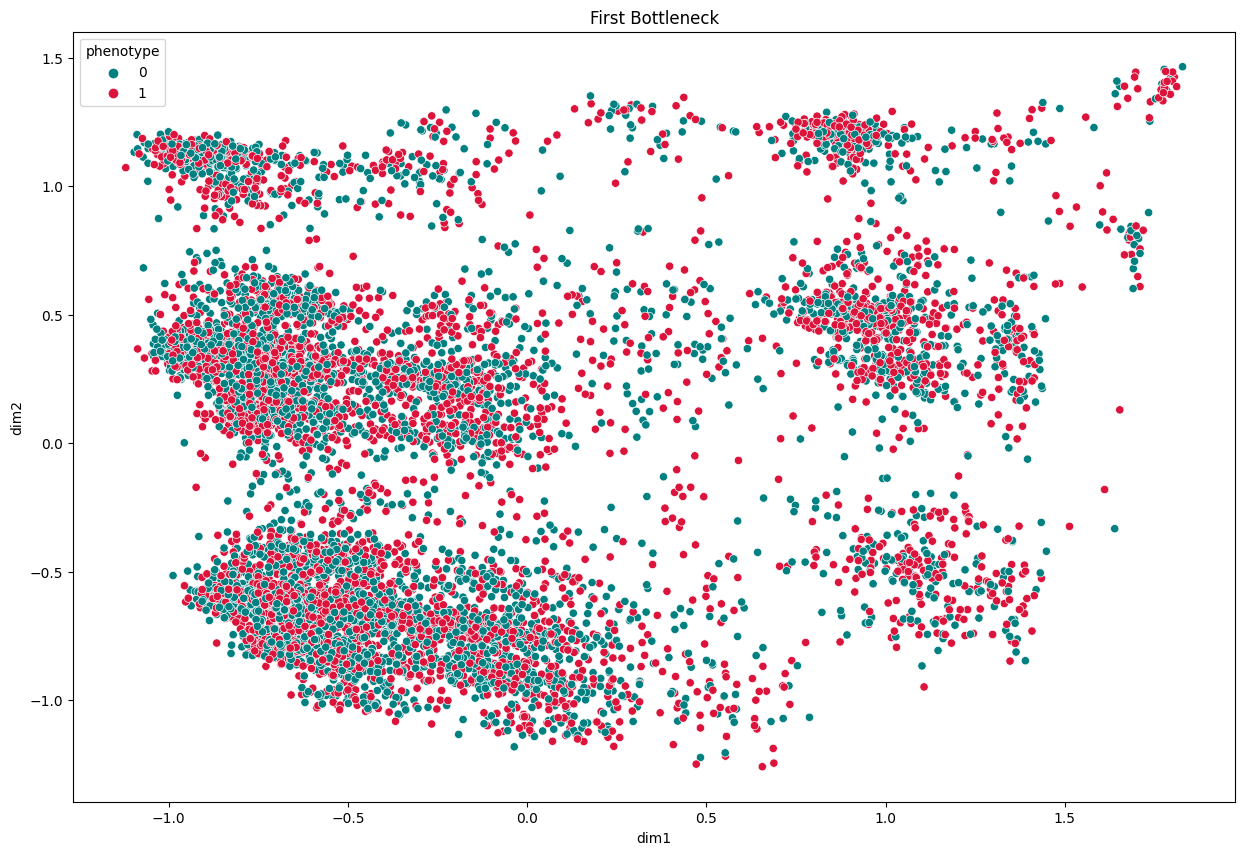

In [89]:
create_plot(bottleneck_1['phenotype'], bottleneck_1, 'dim1', 'dim2', 'First Bottleneck')

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

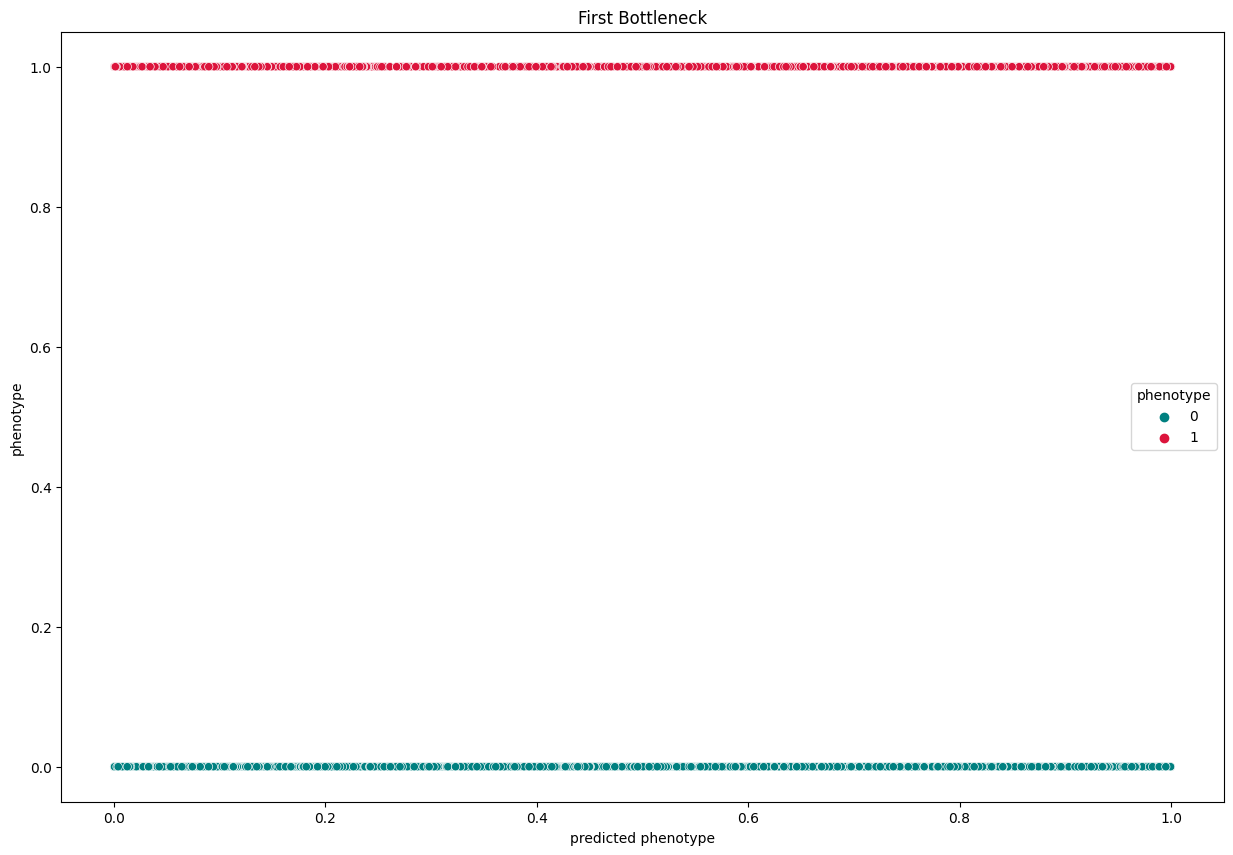

In [90]:
create_plot(bottleneck_1['phenotype'], bottleneck_1, 'predicted phenotype', 'phenotype', 'First Bottleneck')

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [92]:
# Split the data into features (X) and labels (Y)
X = bottleneck_1[['predicted phenotype']]
Y = bottleneck_1['phenotype']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build a simple neural network model
model2 = keras.Sequential([
    keras.layers.Input(shape=(1,)),  # Input layer with 1 feature
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
185/185 [==============================] - 1s 4ms/step - loss: 0.5353 - accuracy: 0.7884 - val_loss: 0.4356 - val_accuracy: 0.8435
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 0.4228 - accuracy: 0.8411 - val_loss: 0.4228 - val_accuracy: 0.8421
Epoch 3/10
185/185 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8411 - val_loss: 0.4220 - val_accuracy: 0.8421
Epoch 4/10
185/185 [==============================] - 1s 3ms/step - loss: 0.4197 - accuracy: 0.8411 - val_loss: 0.4218 - val_accuracy: 0.8428
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 0.4198 - accuracy: 0.8423 - val_loss: 0.4218 - val_accuracy: 0.8394
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.4199 - accuracy: 0.8406 - val_loss: 0.4218 - val_accuracy: 0.8421
Epoch 7/10
185/185 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8423 - val_loss: 0.4226 - val_accuracy: 0.8421
Epoch 

# Now with the validation data

In [93]:
replicated_cases

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
11341,4123168,1,879.506898,2,2,2,2,2,2,2,...,2,1,1,1,2,2,2,2,2,2
5272,2429785,1,365.474370,0,1,2,2,2,2,2,...,2,1,2,2,2,2,0,1,1,2
13170,4610761,1,-90.273344,1,1,2,2,2,2,2,...,1,0,1,1,1,1,1,2,2,2
476,1134197,1,625.116963,2,2,1,0,0,0,0,...,2,1,1,1,0,0,1,1,0,1
8080,3209865,1,508.143764,1,2,2,0,0,0,0,...,2,1,2,2,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12477,4429296,1,-26.150986,2,2,2,0,0,0,0,...,1,0,1,1,1,1,1,2,2,2
11461,4155414,1,253.920942,2,2,2,1,1,1,1,...,2,0,1,1,2,2,0,2,2,2
10392,3875059,1,-359.600709,2,2,2,1,1,1,1,...,1,1,1,1,1,1,2,2,2,2
10767,3969571,1,-131.092246,2,2,2,1,1,1,0,...,2,2,2,2,1,1,1,1,0,2


In [94]:
replicated_controls

,FID,phenotype,PRS,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
10050,3770062,0,-367.021996,1,1,1,1,1,1,1,...,1,1,2,2,2,2,1,2,2,2
11350,4124868,0,261.463605,2,2,2,0,0,0,0,...,2,0,1,2,2,0,2,1,1,2
5144,2391984,0,-699.467153,2,2,1,2,2,2,2,...,2,1,2,2,1,1,2,1,1,2
13248,4629532,0,621.948044,1,1,2,0,0,0,0,...,1,0,1,1,1,1,2,2,2,1
477,1134808,0,-21.295969,2,2,2,1,1,1,1,...,2,1,1,1,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12591,4457776,0,-255.302690,1,1,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,1
11480,4160762,0,-533.914158,1,1,1,0,0,0,0,...,1,0,2,2,2,2,0,1,1,2
10375,3871586,0,-156.083884,2,2,2,1,1,1,1,...,1,2,1,1,0,0,2,1,1,2
10793,3976274,0,244.895714,2,2,2,1,1,1,2,...,1,2,2,2,2,2,1,1,1,1


In [95]:
geno = pd.concat([replicated_cases,train_controls], axis = 0)

In [96]:
genos = geno.sample(frac=1)
pheno = genos[['phenotype']].astype(int)
genos = genos.drop(to_drop, axis=1)
genos = genos - 1
genos

,21:15711567:G_T_T,21:15720497:A_G_A,21:15999828:A_G_G,21:16263419:C_G_C,21:16263440:C_T_T,21:16266353:C_T_C,21:16288177:G_T_G,21:16295354:C_T_C,21:16298857:G_T_G,21:16353531:C_T_T,...,22:48273871:C_T_C,22:49179546:C_T_C,22:49331012:A_G_G,22:49336646:A_G_G,22:49803008:A_C_A,22:49803587:G_T_G,22:49911222:G_T_G,22:50456791:A_G_G,22:50457762:A_G_A,22:51091914:C_T_C
940,1,1,1,0,0,0,1,1,1,1,...,0,1,1,1,1,1,1,0,0,0
10868,1,1,1,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4674,1,1,1,-1,-1,-1,0,0,1,0,...,0,1,1,1,-1,-1,1,0,0,1
5255,1,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,-1,0,0,1
3684,1,1,1,0,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1,1,1,-1,-1,0,0,0,-1,0,...,1,0,1,1,1,1,1,0,0,0
15231,1,1,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,1
5746,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
5735,0,1,1,0,0,0,0,0,0,1,...,1,1,1,1,0,0,1,0,0,1


In [97]:
X1 = tf.convert_to_tensor(genos, dtype=tf.float32)
X2 = tf.convert_to_tensor(pheno, dtype=tf.float32)
output_model = model([X1,X2])
submodel_layers1 = model.layers[:3]
submodel1 = Model(inputs=[model.input[0]], outputs=submodel_layers1[-1].output)
submodel1(X1)

<tf.Tensor: shape=(9226, 2), dtype=float32, numpy=
array([[-0.20464623, -0.785099  ],
       [-0.9192065 ,  1.1012901 ],
       [ 1.3179038 ,  0.36526027],
       ...,
       [-0.6685144 , -0.76468205],
       [-0.4455967 , -0.87726915],
       [-0.7892127 , -0.5874523 ]], dtype=float32)>

In [98]:
submodel_layers2 = model.layers[:6]
submodel2 = Model(inputs=[model.input[0]], outputs=submodel_layers2[-1].output)
submodel2(X1)

<tf.Tensor: shape=(9226, 1), dtype=float32, numpy=
array([[0.44423318],
       [0.05602199],
       [0.17641485],
       ...,
       [0.05927119],
       [0.36734438],
       [0.08393881]], dtype=float32)>

In [99]:
submodel_layers3 = model.layers[:16]
submodel3 = Model(inputs=[model.input[0]], outputs=submodel_layers3[-1].output)
submodel3(X1)

<tf.Tensor: shape=(9226, 302), dtype=float32, numpy=
array([[0.09963382, 0.71309227, 0.28879082, ..., 0.10338716, 0.08623986,
        0.13169768],
       [1.0608736 , 1.0855495 , 0.28891063, ..., 0.10346182, 0.08638011,
        0.40580845],
       [1.4569802 , 0.09356315, 0.28887346, ..., 0.10343867, 0.0863366 ,
        0.40583503],
       ...,
       [0.60730374, 0.6790992 , 0.21390337, ..., 0.10346119, 0.08637893,
        0.40580913],
       [0.30975336, 0.8772696 , 0.21398516, ..., 0.10340194, 0.08626764,
        0.40587723],
       [0.8100168 , 0.41840473, 0.21390992, ..., 0.46016353, 0.49859452,
        0.4058146 ]], dtype=float32)>

In [100]:
cols = []
for i2 in range(np.shape(submodel1(X1))[1]):
    cols.append(f'dim{i2+1}')
bottleneck_1 = pd.DataFrame(submodel1(X1), columns = cols)
cols = []
for i2 in range(np.shape(submodel2(X1))[1]):
    cols.append(f'pheno{i2+1}')
predicted_pheno = pd.DataFrame(submodel2(X1), columns = cols)

In [101]:
bottleneck_1['phenotype'] = list(pheno['phenotype'])
bottleneck_1['predicted phenotype'] = list(predicted_pheno['pheno1'])

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

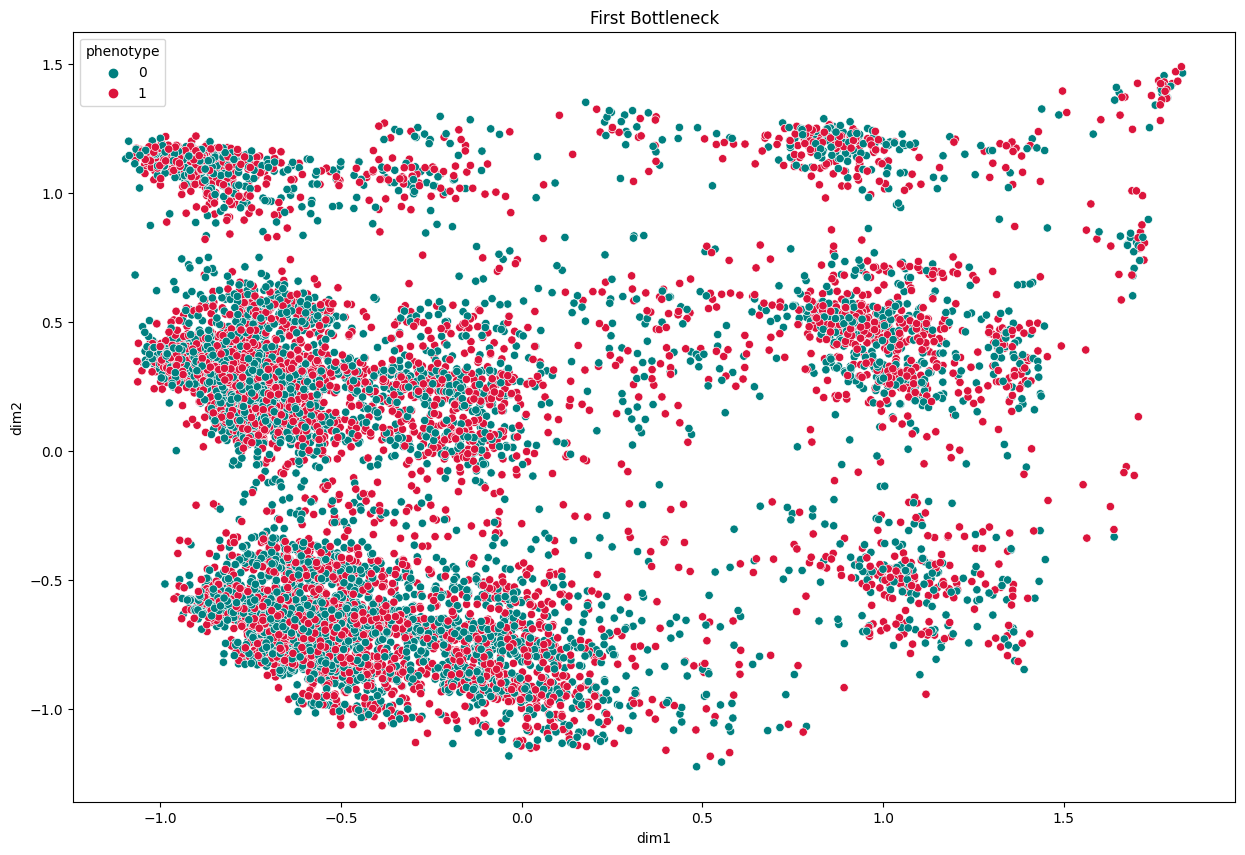

In [102]:
create_plot(bottleneck_1['phenotype'], bottleneck_1, 'dim1', 'dim2', 'First Bottleneck')

<module 'matplotlib.pyplot' from '/home/mat2m10/.pyenv/versions/3.10.6/envs/ctg/lib/python3.10/site-packages/matplotlib/pyplot.py'>

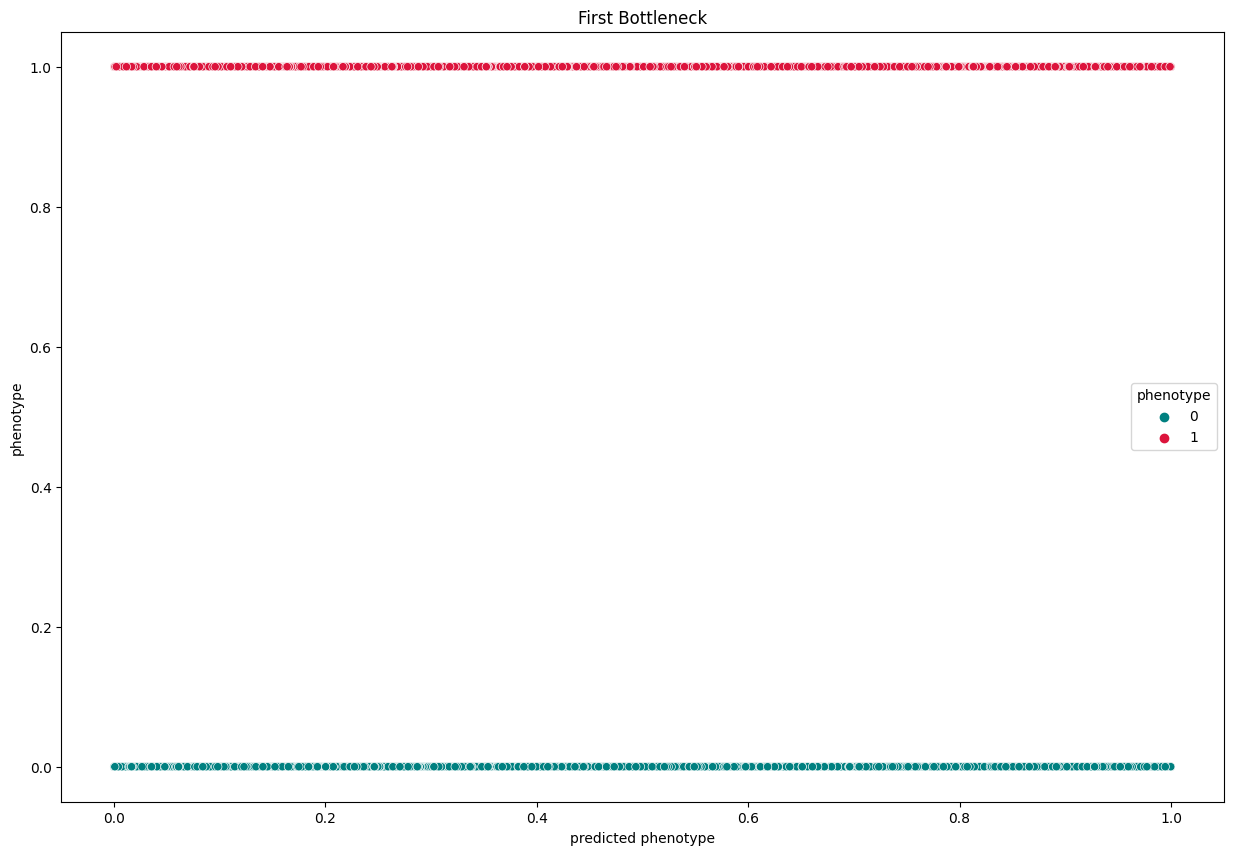

In [103]:
create_plot(bottleneck_1['phenotype'], bottleneck_1, 'predicted phenotype', 'phenotype', 'First Bottleneck')

In [104]:
# Split the data into features (X) and labels (Y)
X = bottleneck_1[['predicted phenotype']]
Y = bottleneck_1['phenotype']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build a simple neural network model
model2 = keras.Sequential([
    keras.layers.Input(shape=(1,)),  # Input layer with 1 feature
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
185/185 [==============================] - 1s 4ms/step - loss: 0.6290 - accuracy: 0.6643 - val_loss: 0.6194 - val_accuracy: 0.6775
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6017 - accuracy: 0.6924 - val_loss: 0.6210 - val_accuracy: 0.6755
Epoch 3/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6016 - accuracy: 0.6939 - val_loss: 0.6202 - val_accuracy: 0.6816
Epoch 4/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6015 - accuracy: 0.6919 - val_loss: 0.6197 - val_accuracy: 0.6829
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6011 - accuracy: 0.6975 - val_loss: 0.6203 - val_accuracy: 0.6822
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.6931 - val_loss: 0.6198 - val_accuracy: 0.6782
Epoch 7/10
185/185 [==============================] - 1s 3ms/step - loss: 0.6013 - accuracy: 0.6938 - val_loss: 0.6200 - val_accuracy: 0.6789
Epoch 

In [107]:
pheno = pd.read_pickle(f"{path}/pheno_PRS.pkl")
pheno

,FID,IID,na1,na2,na3,phenotype,PRS
0,1000133,1000133,0,0,0,1,-195.823928
1,1000368,1000368,0,0,0,1,264.081506
2,1000566,1000566,0,0,0,1,285.314179
3,1000617,1000617,0,0,0,1,-10.446365
4,1000655,1000655,0,0,0,0,-434.138697
...,...,...,...,...,...,...,...
18450,6025070,6025070,0,0,0,1,953.791009
18451,6025369,6025369,0,0,0,1,-212.666886
18452,6025436,6025436,0,0,0,1,375.888514
18453,6025535,6025535,0,0,0,1,29.866073


In [108]:
# Split DataFrame into controls to train the model and cases and controls to calculate PRS
cases_df = pheno[pheno['phenotype'] == 1]
controls_df = pheno[pheno['phenotype'] == 0]
controls_df = controls_df.sample(frac=1, random_state=42)
train_controls = controls_df.head(len(controls_df)//2)
replicated_controls = controls_df.tail(len(controls_df) - len(controls_df)//2)
smallest_size = min(len(train_controls), len(replicated_controls), len(cases_df))


cases_df = cases_df.head(smallest_size)
train_controls = train_controls.head(smallest_size)
replicated_controls = replicated_controls.head(smallest_size)

In [109]:
pheno = pd.concat([cases_df, replicated_controls], axis = 0)

In [110]:
# Split the data into features (X) and labels (Y)
X = pheno[['PRS']]
Y = pheno['phenotype']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build a simple neural network model
model2 = keras.Sequential([
    keras.layers.Input(shape=(1,)),  # Input layer with 1 feature
    keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(X_test, Y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
185/185 [==============================] - 1s 4ms/step - loss: 1.9539 - accuracy: 0.5601 - val_loss: 0.8807 - val_accuracy: 0.5068
Epoch 2/10
185/185 [==============================] - 1s 3ms/step - loss: 0.8508 - accuracy: 0.5696 - val_loss: 0.8839 - val_accuracy: 0.6125
Epoch 3/10
185/185 [==============================] - 0s 2ms/step - loss: 0.7498 - accuracy: 0.5639 - val_loss: 0.7384 - val_accuracy: 0.4986
Epoch 4/10
185/185 [==============================] - 0s 3ms/step - loss: 0.7351 - accuracy: 0.5783 - val_loss: 0.7467 - val_accuracy: 0.6131
Epoch 5/10
185/185 [==============================] - 1s 3ms/step - loss: 0.8874 - accuracy: 0.5550 - val_loss: 0.7153 - val_accuracy: 0.6098
Epoch 6/10
185/185 [==============================] - 1s 3ms/step - loss: 0.7870 - accuracy: 0.5578 - val_loss: 0.6631 - val_accuracy: 0.6009
Epoch 7/10
185/185 [==============================] - 0s 2ms/step - loss: 0.8155 - accuracy: 0.5535 - val_loss: 0.6736 - val_accuracy: 0.6070
Epoch 